## Estensione del tirocinio: Graph Embeddings
<div style="text-align: center;">
<img src="single_files/img/embedding.png" width="50%" height="50%" alt="embedding">
</div><br>
Il progetto si concentra sull'analisi delle giornate di un anno con particolare attenzione ai flussi degli spostamenti turistici tra i punti di interesse (POI) della città di Verona.<br>
L'obiettivo è rappresentare e categorizzare (clusterizzare) le diverse giornate in base ai flussi turistici, utilizzando tecniche di <b>Graph Neural Network</b> e <b>Graph Embedding</b> per estrarre informazioni significative dai dati degli spostamenti.<hr> 

#### Importazione di librerie e file utili

In [156]:
import pandas as pd         
import networkx as nx  
import pickle 
import torch
import torch.nn as nn
import torch_scatter
import plotly.express as px
import sklearn.cluster as skl
import matplotlib.pyplot as plt
from torch_geometric.data import Data, Batch
from torch_geometric.nn import global_add_pool
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from single_files.matrix import *
from single_files.graph import *

# da modificare ad ogni esecuzione per ottenere gli embedding e clustering desiderati
out_dim = 2
year = '2018'
POI_distance_csv = 'csv_files/poi_distances.csv'
embeddings_csv = f'results+distance/{year}/embeddings/emb_{year}_outDim{out_dim}.csv'
clusters_csv = f'results+distance/{year}/clustering/clusters_{year}_outDim{out_dim}.csv'
timeline_html = f'results+distance/{year}/timelines/timeline_{year}_outDim{out_dim}.html'

#### Caricamento del dataset VeronaCard 

In [130]:
df = pd.read_csv('csv_files/log_veronaCard.csv')
POIs = sorted(df.iloc[:, 4].unique())

df_year = df[(df.iloc[:, 0] >= f'{year}-01-01') & (df.iloc[:, 0] <= f'{year}-12-31')]

unique_dates = sorted(df_year.iloc[:, 0].unique())

print(f"Dataset caricato correttamente.")

Dataset caricato correttamente.


#### Generazione grafi da trasformare in embedding
Viene creato un grafo per ogni singola data nel dataset avente almeno uno spostamento da un POI ad un altro, usando le funzioni definite nelle classi 'matrix.py' e 'graph.py'. <br>La funzione get_graph(...) della classe graph.py restituisce un grafo rappresentato come oggetto di tipo networkx e richiede in input una matrice di adiacenza, generata dalla funzione get_matrix(..., ...) della classe matrix.py.<hr>
I grafi generati vengono salvati in un file: in questo modo si può evitare di eseguire più volte il blocco di codice, visto il suo alto tempo di esecuzione<br>
Il codice è commentato perché non sia eseguito più di una volta.

In [72]:
"""

graphs = {}

# generazione dei grafi usando le funzioni definite in matrix.py e graph.py
for date in unique_dates:
    df_date = df_year[df_year.iloc[:, 0] == date]
    graphs[date] = Graph.get_graph(Matrix.get_matrix(df_date, POIs), df_date)
    print(date)

with open(f'saved_graphs/saved_graphs_{year}.pkl', 'wb') as f:
    pickle.dump(graphs, f)

print(f'Grafi salvati in saved_graphs/saved_graphs_{year}.pkl')

"""

"\n\ngraphs = {}\n\n# generazione dei grafi usando le funzioni definite in matrix.py e graph.py\nfor date in unique_dates:\n    df_date = df_year[df_year.iloc[:, 0] == date]\n    graphs[date] = Graph.get_graph(Matrix.get_matrix(df_date, POIs), df_date)\n    print(date)\n\nwith open(f'saved_graphs/saved_graphs_{year}.pkl', 'wb') as f:\n    pickle.dump(graphs, f)\n\nprint(f'Grafi salvati in saved_graphs/saved_graphs_{year}.pkl')\n\n"

#### Caricamento dei grafi precedentemente salvati

In [131]:
with open(f'saved_graphs/saved_graphs_{year}.pkl', 'rb') as g:
    graphs = pickle.load(g)

#### Definizione della funzione *graph_to_pyg*, che trasforma i grafi in oggetti PyTorch Geometric (tensori)
<div style="text-align: center;">
<img src="single_files/img/tensore.png" width="30%" height="30%"  alt="embedding">
</div><br>
La funzione graph_to_pyg(...) è ciò che consente ai dati di essere manipolati dal modello: essa converte i grafi di Networkx in oggetti PyTorch Geometric, rendendoli compatibili con il modello di Graph Neural Network successivamente implementato.

In [132]:
def graph_to_pyg(graph):
    graph = nx.convert_node_labels_to_integers(graph)
    print(graph.nodes)

    # .t() per ottenere un tensore della forma richiesta da PyG
    edge_index = torch.tensor(list(graph.edges)).t()  
    print(edge_index)                             

    # i pesi di tutti gli archi del grafo in un tensore PyTorch (feature degli archi)
    edge_attrs = [
        [graph[u][v]['weight'], graph[u][v]['distance']]
        for u, v in graph.edges
    ]
    edge_weight = torch.tensor(edge_attrs, dtype=torch.float)
    print(edge_weight)
    
    # dummy embedding, nel nostro caso usato per non fornire i nodi di feature specifiche
    x = torch.ones((graph.number_of_nodes(), 1))

    # Data è l'oggetto nel formato standard PyTorch per rappresentare grafi
    return Data(x=x, edge_index=edge_index, edge_weight=edge_weight, num_nodes=graph.number_of_nodes())

#### Definizione della Graph Neural Network
La classe EdgeGNN implementa un modello di rete neurale in PyTorch che genera un graph embedding basato sugli archi invece che sui nodi.
<br>Questa soluzione è più adatta al nostro contesto: nel lavoro svolto durante il tirocinio, infatti, l'attenzione si è concentrata sulla similarità tra grafi a livello di flussi e non a livello strutturale. Di conseguenza, i nodi non forniranno informazioni rilevanti per la generazione degli embedding.

In [133]:
in_dim = 1

edge_dim = 2

In [179]:
class EdgeGNN(nn.Module):
    def __init__(self, in_dim, edge_dim, out_dim):
        super().__init__()
        
        # rete neurale completamente connessa applicata agli archi del grafo
        self.mlp = nn.Sequential(
            # layer lineare che prende in ingresso le feature concatenate di due nodi e dell'arco che li connette, in uscita out_dim
            nn.Linear(in_dim * 2 + edge_dim, out_dim),
            
            # funzione di attivazione ReLU non lineare che permette alla rete di apprendere modelli complessi
            nn.ReLU(),
            
            # trasformazione ulteriore dell'embedding dell'arco
            nn.Linear(out_dim, out_dim)
        )
        
        # funzione di PyTorch Geometric per aggregare gli embedding di tutti gli archi in unico embedding del grafo
        self.global_pool = global_add_pool
    
    def forward(self, data):
        # estrazione della lista degli archi: 'data.edge_index' è una matrice 2 x num_edges
        start_nodes, end_nodes = data.edge_index

        # torch.cat(..., dim=1): concatena le feature lungo l'asse 1
        edge_features = torch.cat([data.x[start_nodes], data.x[end_nodes], data.edge_weight], dim=1)

        # si applica la rete MLP per calcolare l'embedding di ogni arco
        edge_embeddings = self.mlp(edge_features)

        # torch_scatter.scatter_add() esegue una aggregazione di tutti gli embedding degli archi per ogni grafo nel batch
        # data.batch[data.edge_index[0]] mappa ogni arco al batch di appartenenza
        graph_embedding = torch_scatter.scatter_add(edge_embeddings, data.batch[data.edge_index[0]], dim=0)
        return graph_embedding

#### Generazione degli embedding a partire dai grafi

Si inseriscono i grafi, dopo la conversione ad oggetti PyTorch Geometric, in un batch che li racchiude tutti.<br>
Successivamente si inizializza il modello di rete neurale e si convertono gli oggetti interni al batch in embedding.

In [180]:
pyg_list = []

for graph in graphs.values():
    pyg_list.append(graph_to_pyg(graph))

pyg_data_batch = Batch.from_data_list(pyg_list)

model = EdgeGNN(in_dim=in_dim, edge_dim=edge_dim, out_dim=out_dim)

# imposta il modello in modalità inferenziale, per fare previsioni
model.eval()

# .detach(): no retropropagazione
# graph_embeddings: matrice di dimensione (~365, out_dim)
graph_embeddings = model(pyg_data_batch).detach().numpy()

embeddings = [[date] + list(graph_embeddings[i]) for i, date in enumerate(unique_dates)]

c_names = ['date'] + [f'v{i}' for i in range(out_dim)]

embeddings_df = pd.DataFrame(embeddings, columns=c_names)
embeddings_df.to_csv(embeddings_csv, index=False)
print(f'Embeddings calcolati e salvati in {embeddings_csv}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
tensor([[ 1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
          5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,
          8,  8,  9,  9,  9,  9,  9,  9, 10],
        [ 2,  3,  5,  6,  7,  8,  9,  1,  3,  5,  6,  7,  8,  9,  1,  2,  5,  6,
          1,  2,  3,  6,  9, 10,  1,  2,  3,  5,  9,  1,  2,  3,  6,  3,  5,  6,
          7,  9,  1,  2,  5,  6,  8, 10,  3]])
tensor([[3.0000e+00, 1.0836e+03],
        [4.0000e+00, 8.9202e+02],
        [1.8000e+01, 5.7701e+02],
        [3.7000e+01, 4.1315e+02],
        [2.0000e+00, 7.2496e+02],
        [4.0000e+00, 1.7166e+03],
        [3.4000e+01, 6.6938e+02],
        [2.0000e+00, 1.0836e+03],
        [1.0000e+00, 3.6696e+02],
        [2.0000e+00, 6.1236e+02],
        [1.5000e+01, 7.5152e+02],
        [5.0000e+00, 1.0508e+03],
        [2.0000e+00, 1.8947e+03],
        [3.0000e+00, 1.2135e+03],
        [7.0000e+00, 8.9202e+02],
        [1.2000e+01, 3

#### Metodo del gomito per stabilire il numero di cluster opportuno
I seguenti blocchi di codice utili per il clustering sono ripresi dal progetto svolto durante il tirocinio.

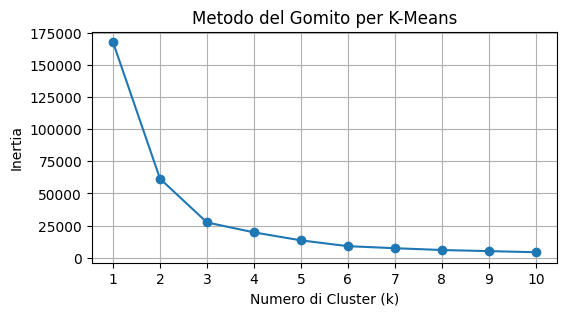

In [157]:
df = pd.read_csv(embeddings_csv)

X = df.iloc[:, 1:].values

# calcolo dell'intertia per ogni valore di k
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 3))
plt.plot(k_range, inertias, marker='o')
plt.title('Metodo del Gomito per K-Means')
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

#### Generazione dei cluster usando K-Means

In [158]:
X = df.iloc[:, 1:].values 

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=1)
df['cluster'] = kmeans.fit_predict(X)

df = df.drop(df.columns[1:out_dim + 1], axis=1)
df.to_csv(clusters_csv, index=False)
print(f'Clustering completato! I risultati sono salvati in {clusters_csv}')

Clustering completato! I risultati sono salvati in results+distance/2018/clustering/clusters_2018_outDim2.csv


#### Visualizzazione Timeline per analizzare i cluster ottenuti

In [159]:
df = pd.read_csv(clusters_csv)

df['date'] = pd.to_datetime(df['date'])
df['size'] = 8  
df['y_pos'] = 0 

fig = px.scatter(df, 
                 x='date', 
                 y='y_pos',  
                 color='cluster',  
                 size='size', 
                 size_max=15, 
                 title="Timeline dei Cluster",
                 labels={'cluster': 'Cluster', 'date': 'Data'},
                 template="plotly_dark", 
                 hover_data={'y_pos': False, 'size': False})  

fig.update_yaxes(visible=False)

fig.update_layout(
    yaxis=dict(
        scaleanchor="x", 
        fixedrange=True
    )
)
fig.show()
fig.write_html(timeline_html)

#### Analisi indici di silhouette

#### 1. Tirocinio

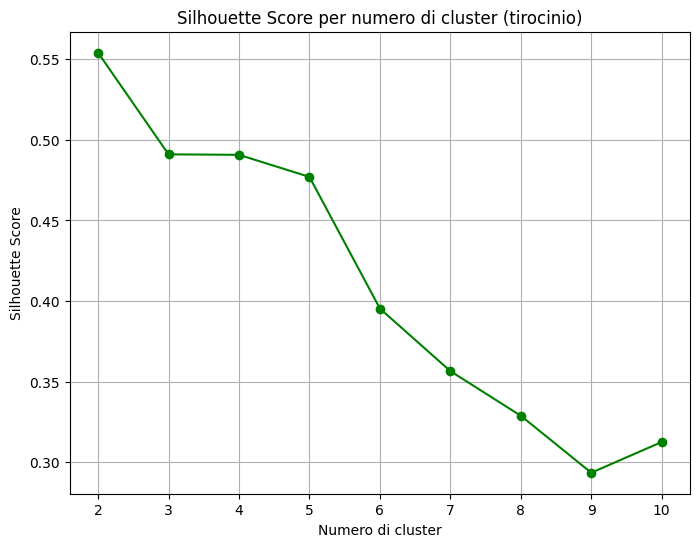

In [153]:
def KMeans_clustering():
    distance_matrix = pd.read_csv('csv_files/2_2018_WEIGHT_distance_matrix.csv', index_col=0)
    # Un vettore per ogni data
    distance_values = distance_matrix.values
    
    silhouette_scores = []

    for n in range(2, 11):
        kMeans = skl.KMeans(n_clusters=n, random_state=0)
        labels = kMeans.fit_predict(distance_values)
        score = silhouette_score(distance_values, labels)
        silhouette_scores.append(score)    

    # Plot del Silhouette Score
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
    plt.title('Silhouette Score per numero di cluster (tirocinio)')
    plt.xlabel('Numero di cluster')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, 11))
    plt.grid(True)
    plt.show()

KMeans_clustering()

#### 2. Embedding utilizzando pesi degli archi e distanza tra POI come feature

0.645690120153443
0.6190231047549428
0.5557576700650935
0.5205220384219488
0.5185473446282406
0.5240202079089912
0.518879245543626
0.5217801694013536
0.5238743097949351


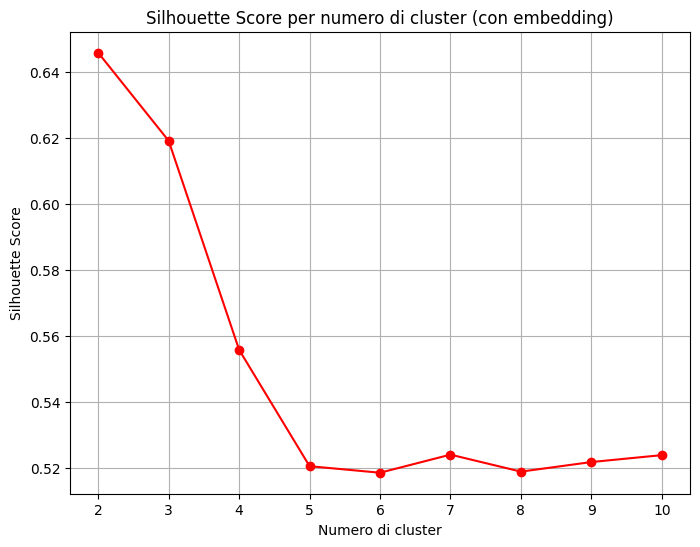

In [181]:
def KMeans_clustering():
    embeddings = pd.read_csv(embeddings_csv, index_col=0)
    
    values = embeddings.values
    
    silhouette_scores = []

    for n in range(2, 11):
        kMeans = skl.KMeans(n_clusters=n, random_state=0)
        labels = kMeans.fit_predict(values)
        score = silhouette_score(values, labels)
        print(score)
        silhouette_scores.append(score)    

    # Plot del Silhouette Score
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, 11), silhouette_scores, marker='o', color='red')
    plt.title('Silhouette Score per numero di cluster (con embedding)')
    plt.xlabel('Numero di cluster')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, 11))
    plt.grid(True)
    plt.show()

KMeans_clustering()

### Fonti

* [Documentazione ufficiale di PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html)
* [Esempi ufficiali di applicazione di PyTorch Geometric su GitHub](https://github.com/pyg-team/pytorch_geometric)
* [Build a Graph Neural Network with PyTorch Geometric](https://medium.com/%40rjnclarkebuild-a-graph-neural-network-with-pytorch-geometric-fd7918345fa8)